In [5]:
# necessary libraries, functions, and constants
import csv
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from PIL import Image
from sklearn import discriminant_analysis
from sklearn import metrics
from sklearn import model_selection
from sklearn import neighbors
from timeit import default_timer as timer

classes = ['ocean', 'ship', 'shore', 'sky']

# options
oversample = False


def prepare_data(input_file, description, oversample=False):
    """
    prepares the data, also prints some information about it
    """
    y = []
    X = []
    y_numeric = []
    
    print("\n##############\n%s Data summary:" % (description))
    with open(input_file, 'r') as csvfile:
        data_reader = csv.reader(csvfile, dialect='excel')
        for row in data_reader:
            if len(row) > 0:
                y.append(row[0])
                X_float = [ float(x) for x in row[1:] ]
                X.append(X_float)

    # create a y_numeric for use with tensorflow
    for obs in y:
        y_numeric.append(classes.index(obs))

    assert len(X) == len(y) == len(y_numeric)

    # convert to np.array objects
    y = np.array(y)
    y_numeric = np.array(y_numeric)
    X = np.array(X)

    # how many features?
    num_features = len(X[0])
    print("%s features" % (num_features))

    # count the classes
    largest_class = "none"
    largest_class_count = -1

    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))

    for key in class_counts.keys():
        count = class_counts[key]
        if count > largest_class_count:
            largest_class_count = count
            largest_class = key

    # raw data stats            
    print("Raw observations:")
    print("%s observations" % (len(y)))
    print("Class counts:")
    for cl in class_counts.keys():
        print("%s - %s" % (cl, class_counts[cl]))

    # if desired, use oversampling for any class that has less than 75% of the observations
    # of the largest class
    if oversample == True:
        print("\nOversampling enabled")
        print("Largest class is " + largest_class + " with %s observations" % (largest_class_count))

        for cl in class_counts.keys():
            if class_counts[cl] < 0.8 * largest_class_count:
                # oversample
                X, y = oversample(X, y, cl, largest_class_count)

        class_counts = {}
        for cl in classes:
            class_counts[cl] = y.count(cl)

        print("\nObservations after oversampling:")
        for cl in class_counts.keys():
            print("%s - %s" % (cl, class_counts[cl]))
    
    return X, y, y_numeric


# this function taken from:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() * 0.75
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{0:.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

    
def oversample(X, y, cl, largest_class):
    """
    returns new X and y lists with oversampling
    """
    X_new = list(X)
    y_new = list(y)
    
    # first count each class in y
    class_count = y.count(cl)
    obs_add = largest_class - class_count
    print("oversample - %s samples with %s class in y, adding %s observations" % (class_count, cl, obs_add))
    
    # keep adding samples for the class
    obs_added = 0
    class_index = 0
    all_in_class = [i for i, x in enumerate(y) if x == cl ] # => [1, 4, 6], all indexes for the class
    assert len(all_in_class) > 0
    
    # take observations from the class sequentially, looping around when off the end
    while obs_added < obs_add:
        index = all_in_class[class_index]
        
        y_new.append(y[index])
        X_new.append(X[index])
        
        obs_added += 1
        
        class_index += 1
        if class_index >= len(all_in_class):
            class_index = 0
    
    return X_new, y_new


def next_batch(X, y, offset, step):
    """
    returns a batch of observations and new offset, given offset and step
    if the batch will run off the end, loops back around
    """
    X_batch = []
    y_batch = []
    
    assert len(X) == len(y)
    
    if offset + step >= len(X):
        new_offset = offset + step - len(X)
        X_batch = list(X[offset:])
        X_batch.extend(list(X[:new_offset]))
        y_batch = list(y[offset:])
        y_batch.extend(list(y[:new_offset]))
    else:
        new_offset = offset + step
        X_batch = X[offset:offset + step]
        y_batch = y[offset:offset + step]
    
    return X_batch, y_batch, new_offset


def one_hot(y, classes):
    """
    takes as input a list of response values as strings, returns
    a one-hot matrix given the class ordering provided, and the map
    to return the index to classes
    """
    class_map = {}
    for i, cl in enumerate(classes):
        class_map[i] = cl
        
    one_hot_matrix = []
    for response in y:
        row = [0] * len(classes)
        row[classes.index(response)] = 1
        one_hot_matrix.append(row)
    
    one_hot_matrix = np.array(one_hot_matrix)
    return one_hot_matrix, class_map
    

In [6]:
# import data from data.csv
y_rgb = []
X_rgb = []
y_rgb_numeric = []

y_gray = []
X_gray = []
y_gray_numeric = []

X_rgb, y_rgb, y_rgb_numeric = prepare_data("data_rgb.csv", "RGB 32x32")
X_gray, y_gray, y_gray_numeric = prepare_data("data_gray.csv", "Grayscale 28x28")


##############
RGB 32x32 Data summary:
3072 features
Raw observations:
3347 observations
Class counts:
ship - 2347
ocean - 504
sky - 496

##############
Grayscale 28x28 Data summary:
784 features
Raw observations:
3347 observations
Class counts:
ship - 2347
ocean - 504
sky - 496


In [72]:
# create training and test sets
# first method - split data set into two random sets
# randomly select from the original data into training and test sets

# validation sets
# TODO need to cross-validate the size of the train/test sets
test_set_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def generate_validation_sets(X, y, test_size):
    """
    generates training and test sets using validation set split, given the test_size variable,
    which is a float between 0 and 1
    """
    print("generating train/test split with test size = %s" % (test_size))
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                        y, 
                                                                        test_size=test_size, 
                                                                        random_state=0)
    return X_train, y_train, X_test, y_test

# K-Nearest Neighbors
Inputs: number of neighbors, training and test sets

Outputs: accuracy score, confusion matrix

In [74]:
def knn(X_train, y_train, X_test, y_test):
    """
    Performs K-nearest Neighbors with provided parameters, returns a tuple containing
    k, accuracy, precision, confusion matrix
    """
    # record metrics for the cross-validated value - n-neighbors
    # format of knn_metrics is [index, neighbors, score, confusion matrix]
    # score is the mean accuracy and is provided by the score function of the classifier
    knn_metrics = pd.DataFrame(columns=('neighbors', 'mean_accuracy', 'confusion matrix'))
    
    max_k = int(math.sqrt(len(X_train))/2)
    print("max k = " + str(max_k))

    # TODO - look into parallelizing this
    i = 0
    for k in range(1, max_k + 1):
        start = timer()
        
        classifier = neighbors.KNeighborsClassifier(k, 'distance')
        classifier.fit(X_train, y_train)

        y_prediction = classifier.predict(X_test)
        cm = metrics.confusion_matrix(y_test, y_prediction, labels=classes)
        mean_accuracy = classifier.score(X_test, y_test)
        
        end = timer()
        
        metric = (k, mean_accuracy, cm)
        if k == 1 or k%5 == 0:
            print("k = %s, metric = %s (%ss)" % (k, metric, end - start))
        knn_metrics.loc[i] = metric
        i += 1
    
    return knn_metrics

knn_metrics_rgb = {}
knn_metrics_gray = {}

for t in test_set_sizes:
    print("\n####################\ntest set size = %s" % (t))
    # generate validation sets
    X_train_rgb, y_train_rgb, X_test_rgb, y_test_rgb = generate_validation_sets(X_rgb, y_rgb, t)
    X_train_gray, y_train_gray, X_test_gray, y_test_gray = generate_validation_sets(X_gray, y_gray, t)
    
    # generate metrics for knn for rgb and gray-scale
    print("Color:")
    knn_metrics_rgb[t] = knn(X_train_rgb, y_train_rgb, X_test_rgb, y_test_rgb)
    print("Grayscale:")
    knn_metrics_gray[t] = knn(X_train_gray, y_train_gray, X_test_gray, y_test_gray)


####################
test set size = 0.1
generating train/test split with test size = 0.1
generating train/test split with test size = 0.1
Color:
max k = 27
k = 1, metric = (1, 0.79104477611940294, array([[ 28,  11,   9],
       [ 18, 206,  12],
       [ 14,   6,  31]])) (9.84349285254575s)
k = 5, metric = (5, 0.76716417910447765, array([[ 29,  11,   8],
       [ 23, 204,   9],
       [ 15,  12,  24]])) (10.159136654683607s)
k = 10, metric = (10, 0.77313432835820894, array([[ 25,  15,   8],
       [ 18, 209,   9],
       [ 12,  14,  25]])) (10.378653267278423s)
k = 15, metric = (15, 0.77014925373134324, array([[ 23,  19,   6],
       [ 18, 211,   7],
       [  9,  18,  24]])) (10.392737476709954s)
k = 20, metric = (20, 0.76119402985074625, array([[ 20,  22,   6],
       [ 16, 214,   6],
       [  8,  22,  21]])) (10.379731513154184s)
k = 25, metric = (25, 0.74925373134328355, array([[ 18,  23,   7],
       [ 16, 213,   7],
       [ 11,  20,  20]])) (10.497039049887462s)
Grayscale:
max

In [75]:
# determine mean mean accuracy for each test set size
print(knn_metrics_rgb)
print(knn_metrics_gray)

mean_mean_accuracies = {}
highest_mean_accuracy = -1

for key in knn_metrics_rgb.keys():
    means = knn_metrics_rgb[key].mean()
    mean_mean_accuracies[key] = means['mean_accuracy']
    
    if means['mean_accuracy'] > highest_mean_accuracy:
        highest_mean_accuracy = means['mean_accuracy']
    

max_accuracy_rgb = knn_metrics_rgb.loc[knn_metrics_rgb['mean_accuracy'].idxmax()]
print("best mean accuracy for RGB = %s @ k = %s" % (max_accuracy_rgb['mean_accuracy'], max_accuracy_rgb['neighbors']))

max_accuracy_gray = knn_metrics_gray.loc[knn_metrics_gray['mean_accuracy'].idxmax()]
print("best mean accuracy for grayscale = %s @ k = %s" % (max_accuracy_gray['score'], max_accuracy_gray['neighbors']))


{0.1:     neighbors  mean_accuracy                             confusion matrix
0         1.0       0.791045    [[28, 11, 9], [18, 206, 12], [14, 6, 31]]
1         2.0       0.791045    [[28, 11, 9], [18, 206, 12], [14, 6, 31]]
2         3.0       0.779104     [[28, 11, 9], [20, 207, 9], [16, 9, 26]]
3         4.0       0.773134  [[28, 10, 10], [21, 205, 10], [15, 10, 26]]
4         5.0       0.767164    [[29, 11, 8], [23, 204, 9], [15, 12, 24]]
5         6.0       0.764179    [[26, 13, 9], [24, 204, 8], [13, 12, 26]]
6         7.0       0.761194  [[25, 12, 11], [21, 205, 10], [13, 13, 25]]
7         8.0       0.758209   [[25, 17, 6], [21, 205, 10], [13, 14, 24]]
8         9.0       0.773134   [[26, 14, 8], [16, 210, 10], [14, 14, 23]]
9        10.0       0.773134    [[25, 15, 8], [18, 209, 9], [12, 14, 25]]
10       11.0       0.779104    [[25, 16, 7], [18, 209, 9], [10, 14, 27]]
11       12.0       0.758209   [[24, 16, 8], [19, 207, 10], [12, 16, 23]]
12       13.0       0.767164    

AttributeError: 'dict' object has no attribute 'loc'

In [42]:
plot_confusion_matrix(max_accuracy_rgb['confusion matrix'], 
                      classes, 
                      title='Normalized confusion matrix RGB images, k=%s' % (int(max_accuracy_rgb['neighbors'])))
plt.show()

plot_confusion_matrix(max_accuracy_gray['confusion matrix'], 
                      classes, 
                      title='Normalized confusion matrix grayscale images, k=%s' % (int(max_accuracy_gray['neighbors'])))
plt.show()


Normalized confusion matrix
[[ 0.50199203  0.40239044  0.09561753]
 [ 0.06448839  0.92605331  0.0094583 ]
 [ 0.23846154  0.34230769  0.41923077]]
Normalized confusion matrix
[[ 0.47410359  0.37450199  0.15139442]
 [ 0.07394669  0.89423904  0.03181427]
 [ 0.26923077  0.28846154  0.44230769]]


In [52]:
rgb_plot, = plt.plot(knn_metrics_rgb['neighbors'], knn_metrics_rgb['mean_accuracy'], label='color accuracy', color='blue')
gray_plot, = plt.plot(knn_metrics_gray['neighbors'], knn_metrics_gray['mean_accuracy'], label='grayscale accuracy', color='red')
plt.title("Mean accuracy")
plt.xlabel("k")
plt.ylabel("mean accuracy")

# show a legend
plt.legend(handles=[rgb_plot, gray_plot], loc=2)

plt.show()

# LDA and QDA
Variables: N/A

Output: accuracy score, confusion matrix

C:\Users\jchadwick\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA Results:
accuracy = 0.553166069295
confusion matrix = 
[[104  90  57]
 [256 735 172]
 [ 80  93  87]]
Normalized confusion matrix
[[ 0.41434263  0.35856574  0.22709163]
 [ 0.22012038  0.63198624  0.14789338]
 [ 0.30769231  0.35769231  0.33461538]]


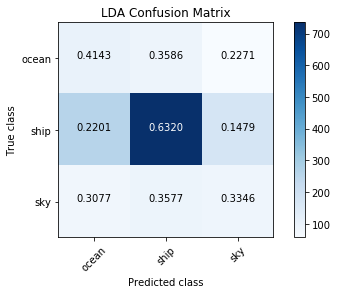

In [8]:
# response has to be numeric for LDA and QDA
y_train_numeric = []
y_test_numeric = []
for cl in y_train:
    y_train_numeric.append(classes.index(cl))

for cl in y_test:
    y_test_numeric.append(classes.index(cl))

# LDA
    
#print(y_train_numeric[:5])
#print(X_train[:5])
classifier = discriminant_analysis.LinearDiscriminantAnalysis()
classifier.fit(X_train, y_train_numeric)

y_prediction = []
y_prediction_num = classifier.predict(X_test)
for pred in y_prediction_num:
    y_prediction.append(classes[pred])

cm = metrics.confusion_matrix(y_test, y_prediction, labels=classes)
accuracy = metrics.accuracy_score(y_test, y_prediction, normalize=True)

print("LDA Results:")
print("accuracy = " + str(accuracy))
print("confusion matrix = ")
print(cm)

plot_confusion_matrix(cm, classes, title="LDA Confusion Matrix")
plt.show()

C:\Users\jchadwick\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA Results:
accuracy = 0.589008363202
confusion matrix = 
[[ 55 166  30]
 [160 891 112]
 [ 49 171  40]]
Normalized confusion matrix
[[ 0.21912351  0.66135458  0.11952191]
 [ 0.13757524  0.7661221   0.09630267]
 [ 0.18846154  0.65769231  0.15384615]]


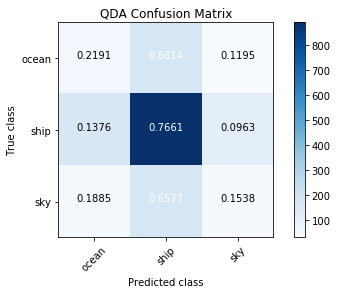

In [9]:
# QDA
classifier = discriminant_analysis.QuadraticDiscriminantAnalysis()
classifier.fit(X_train, y_train_numeric)

y_prediction = []
y_prediction_num = classifier.predict(X_test)
for pred in y_prediction_num:
    y_prediction.append(classes[pred])

cm = metrics.confusion_matrix(y_test, y_prediction, labels=classes)
accuracy = metrics.accuracy_score(y_test, y_prediction, normalize=True)

print("QDA Results:")
print("accuracy = " + str(accuracy))
print("confusion matrix = ")
print(cm)

plot_confusion_matrix(cm, classes, title="QDA Confusion Matrix")
plt.show()

# Softmax Regression (precursor to CNN)

This section is largely adapted from:

https://www.tensorflow.org/get_started/mnist/pros


In [58]:
sess = tf.InteractiveSession()

# setup inputs
# x has 3072 features since it consists of 32x32 pixels
# y_ is a one-hot multi-dimensional vector the size of the number
# of classes
num_features = len(X_train_rgb[0])

x = tf.placeholder(tf.float32, [None, num_features])
y_ = tf.placeholder(tf.int32, [None, len(classes)])

# define weights (W) and biases (b)
W = tf.Variable(tf.zeros([num_features, len(classes)]))
b = tf.Variable(tf.zeros([len(classes)]))

# initialize variables
tf.global_variables_initializer().run()

In [59]:
# implement the regression model
model = tf.matmul(x, W) + b

# specify the loss function
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=model))

# use steepest gradient descent to train the model
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [60]:
# now repeatedly run train_step to perform gradient descent
offset = 0
batch_size = 100
for _ in range(1000):
    X_batch, y_batch, offset = next_batch(X_train_rgb, y_train_rgb, offset, batch_size)
    # generate one-hot encoding for the response
    y_one_hot, class_map = one_hot(y_batch, classes)
    sess.run(train_step, feed_dict={x: X_batch, y_: y_one_hot})

In [62]:
# evaluate the model
y_true = tf.argmax(y_, 1)
y_pred = tf.argmax(model, 1)

predictions = y_pred.eval(feed_dict={ x: X_test_rgb })

# define metric
correct_prediction = tf.equal(y_pred, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

y_one_hot, _ = one_hot(y_test_rgb, classes)
#print(accuracy.eval(feed_dict={x: X_test, y_: y_one_hot}))
accuracy_metric = sess.run(accuracy, feed_dict={x: X_test_rgb, y_: y_one_hot})
print("accuracy = %s" % (accuracy_metric))

sess.close()

# calculate confusion matrix
# return the predictions to class names
class_predictions = []
for pred in predictions:
    class_predictions.append(class_map[pred])
cm = metrics.confusion_matrix(y_test_rgb, np.array(class_predictions))
plot_confusion_matrix(cm, classes, title="Softmax Regression Confusion Matrix")
plt.show()

accuracy = 0.700119
Normalized confusion matrix
[[  4.78087649e-02   9.48207171e-01   3.98406375e-03]
 [  4.29922614e-03   9.94840929e-01   8.59845228e-04]
 [  7.69230769e-02   9.11538462e-01   1.15384615e-02]]


# Convolutional Neural Network

This code adapted from https://www.tensorflow.org/get_started/mnist/pros

In [63]:
# CNN Setup
sess = tf.InteractiveSession()

num_features = len(X_train_gray[0])
num_classes = len(classes)

# placeholders
x = tf.placeholder(tf.float32, [None, num_features])
y_ = tf.placeholder(tf.int32, [None, num_classes])

# initialize weights with small amount of noise
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# give the neurons a slightly positive bias to avoid dead neurons
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# conv2d uses stride of one and are zero-padded - output
# is the same size as the input
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# pooling is max pooling over 2x2 blocks
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1], padding='SAME')

In [64]:
# first convolutional layer
# convolution , followed by max pooling
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# reshape x to a 4d tensor
x_image = tf.reshape(x, [-1, 28, 28, 1])

# reshape x_image with weight tensor, add the bias, apply ReLU function
# finally max pool
# max_pool_2x2 reduces image to 14x14
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [65]:
# second convolutional layer
# 64 features for each 5x5 patch
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

# max_pool_2x2 reduces image size to 7x7
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [66]:
# densely connected layer
# fully-connected layer with 1024 neurons
# reshape the tnsor from the pooling layer into a batch of vectors
# multiply by weight matrix, add a bias, and apply ReLU
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [67]:
# dropout - reduces overfitting
# turned on during training, turned off during testing, controlled by the keep_prob placeholder
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [68]:
# readout layer
W_fc2 = weight_variable([1024, num_classes])
b_fc2 = bias_variable([num_classes])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [69]:
# train and evaluate the model
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

batch_size = 50
iterations = 3000
offset = 0

for i in range(iterations):
    X_batch, y_batch, offset = next_batch(X_train_gray, y_train_gray, offset, batch_size)
    y_batch_one_hot, _ = one_hot(y_batch, classes)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: X_batch, y_: y_batch_one_hot, keep_prob: 1.0 })
        print("step %d, training accuracy %g" % (i, train_accuracy))
    train_step.run(feed_dict={ x: X_batch, y_: y_batch_one_hot, keep_prob: 0.5})

y_test_one_hot, _ = one_hot(y_test_gray, classes)
print("test accuracy %g" % (accuracy.eval(feed_dict={ x: X_test_gray, y_: y_test_one_hot, keep_prob: 1.0})))
    

step 0, training accuracy 0.34
step 100, training accuracy 0.82
step 200, training accuracy 0.9
step 300, training accuracy 0.96
step 400, training accuracy 0.88
step 500, training accuracy 0.84
step 600, training accuracy 0.82
step 700, training accuracy 0.92
step 800, training accuracy 0.96
step 900, training accuracy 1
step 1000, training accuracy 0.94
step 1100, training accuracy 0.94
step 1200, training accuracy 0.94
step 1300, training accuracy 0.94
step 1400, training accuracy 0.9
step 1500, training accuracy 0.98
step 1600, training accuracy 0.98
step 1700, training accuracy 0.98
step 1800, training accuracy 1
step 1900, training accuracy 0.98
step 2000, training accuracy 1
step 2100, training accuracy 1
step 2200, training accuracy 1
step 2300, training accuracy 1
step 2400, training accuracy 1
step 2500, training accuracy 1
step 2600, training accuracy 1
step 2700, training accuracy 1
step 2800, training accuracy 1
step 2900, training accuracy 1
test accuracy 0.848268
